In [62]:
# Constants
db_path = "sqlite:///Instructions/Resources/hawaii.sqlite"
separator = "-----------"

# Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc, select, Column, Integer, String, Float

In [19]:
#Connect to db
engine = create_engine(db_path)
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Create session (link) from Python to the DB
session = Session(engine)

In [26]:
# Inspect tables
inspector = inspect(engine)
inspector.get_table_names()
keys = Base.classes.keys()
print(separator)
for key in keys:
    print(key)
    print(separator)
    columns = inspector.get_columns(key)
    for c in columns:
        print(c['name'], c["type"])
    print(separator)

-----------
measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------
station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
-----------


In [37]:
def string_to_date(text):
    return dt.datetime(int(text[:4]),int(text[5:7]),int(text[8:]))

In [157]:
# Define Queries

# Define query to retrieve all measurement data
all_measurements = select([Measurement.date,\
                           Measurement.prcp.label('precipitation'),\
                           Measurement.station,\
                           Measurement.tobs.label('temperature')])
print("Retrieve all measurements:")
print(all_measurements)

# Define query to retrieve the date and precipitation scores from measurment the last 12 months
max_date = engine.execute('SELECT MAX(date) FROM measurement').fetchall()
last_date = string_to_date(max_date[0][0])
first_date = last_date - dt.timedelta(days=365)
short_first_date = str(first_date)[:10]
short_last_date = str(last_date)[:10]
print(f"\nLast 12 Months Precipitation, Query Dates: {short_first_date} to {short_last_date}")
precipitation = select([Measurement.date,
                        Measurement.prcp.label('precipitation'),\
                        Measurement.station])\
.where(Measurement.date >= short_first_date)
print(precipitation)

# Define query to count the number of stations
station_count = select([Station.id]).count()
print("\nCount number of stations:")
print(station_count)

# Define query to determine which stations take the most measurements
station_activity = select([Measurement.station,\
                           func.count(Measurement.id).label('measurements')])\
.group_by("station")\
.order_by(desc("measurements"))
print("\nOrder the stations by the number of measruements in descending order:")
print(station_activity)

Retrieve all measurements:
SELECT measurement.date, measurement.prcp AS precipitation, measurement.station, measurement.tobs AS temperature 
FROM measurement

Last 12 Months Precipitation, Query Dates: 2016-08-23 to 2017-08-23
SELECT measurement.date, measurement.prcp AS precipitation, measurement.station 
FROM measurement 
WHERE measurement.date >= :date_1

Count number of stations:
SELECT count(id) AS tbl_row_count 
FROM (SELECT station.id AS id 
FROM station)

Order the stations by the number of measruements in descending order:
SELECT measurement.station, count(measurement.id) AS measurements 
FROM measurement GROUP BY measurement.station ORDER BY measurements DESC


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SADeprecationWarning: The FromClause.count() method is deprecated, and will be removed in a future release.   Please use the functions.count function available from the func namespace.


In [159]:
# Save the query results as Pandas DataFrames and verify data structures returned
conn = engine.connect()
all_measures = pd.read_sql(all_measurements,conn)
print(all_measures.head())
print()
year_of_precipitation = pd.read_sql(precipitation,conn)
print(year_of_precipitation.head())
print()
num_stations = pd.read_sql(station_count,conn)
print(num_stations.head())
print()
station_measurements = pd.read_sql(station_activity,conn)
print(station_measurements.head())

         date  precipitation      station  temperature
0  2010-01-01           0.08  USC00519397         65.0
1  2010-01-02           0.00  USC00519397         63.0
2  2010-01-03           0.00  USC00519397         74.0
3  2010-01-04           0.00  USC00519397         76.0
4  2010-01-06            NaN  USC00519397         73.0

         date  precipitation      station
0  2016-08-23           0.00  USC00519397
1  2016-08-24           0.08  USC00519397
2  2016-08-25           0.08  USC00519397
3  2016-08-26           0.00  USC00519397
4  2016-08-27           0.00  USC00519397

   tbl_row_count
0              9

       station  measurements
0  USC00519281          2772
1  USC00519397          2724
2  USC00513117          2709
3  USC00519523          2669
4  USC00516128          2612



Last 12 Months Precipitation Summary Statistics:
       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


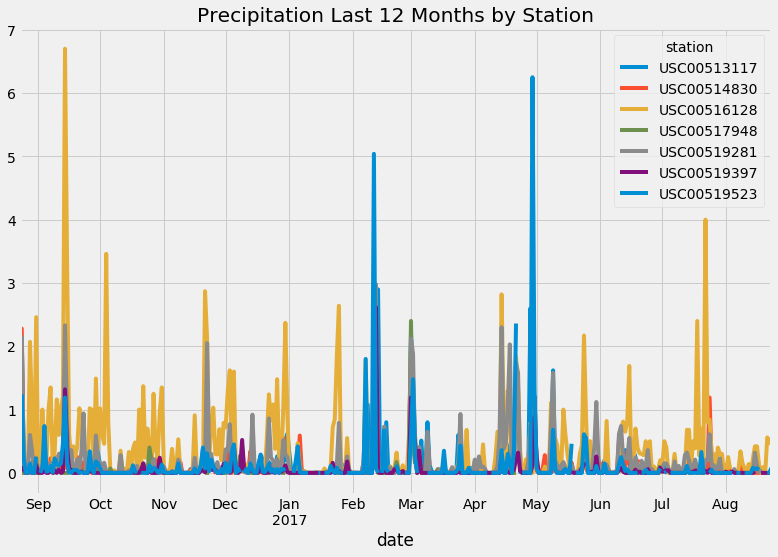

In [273]:
# Precipitation Analysis

print("\nLast 12 Months Precipitation Summary Statistics:")
print(year_of_precipitation.describe())

year_of_precipitation.sort_values("date",inplace=True)
year_of_precipitation["date"] = pd.to_datetime(year_of_precipitation["date"])
year_of_precipitation["precipitation"] = year_of_precipitation["precipitation"].astype(float)
df = year_of_precipitation.groupby(['date','station']).sum().unstack('station')
df.columns = df.columns.droplevel()
df.plot(figsize=(12,8),stacked=False,title="Precipitation Last 12 Months by Station")

Number of Stations: 9

Stations in order of descending activity:
             measurements
station                  
USC00519281          2772
USC00519397          2724
USC00513117          2709
USC00519523          2669
USC00516128          2612
USC00514830          2202
USC00511918          1979
USC00517948          1372
USC00518838           511

Most Active Station: USC00519281

Most Active Station Temperature Statistics:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


<function matplotlib.pyplot.show(*args, **kw)>

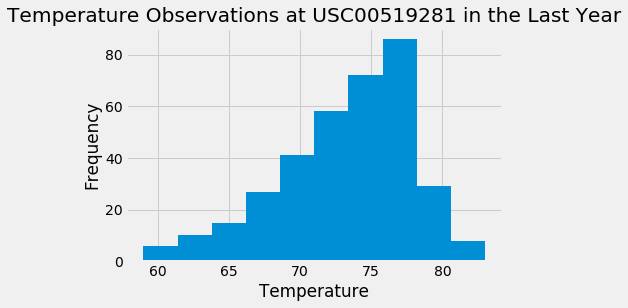

In [199]:
# Station Analysis

print(f"Number of Stations: {num_stations.iloc[0,0]}")
pretty_station_measurements = station_measurements.set_index("station")

print("\nStations in order of descending activity:")
print(pretty_station_measurements)
print(f"\nMost Active Station: {most_active_station}")

print("\nMost Active Station Temperature Statistics:")
most_active_station_measurements = all_measures.loc[all_measures["station"]==most_active_station]
most_active_station_lowest_temp = most_active_station_measurements["temperature"].min()
print(f"Lowest Temperature: {most_active_station_lowest_temp}")
most_active_station_highest_temp = most_active_station_measurements["temperature"].max()
print(f"Highest Temperature: {most_active_station_highest_temp}")
most_active_station_avg_temp = most_active_station_measurements["temperature"].mean()
print(f"Average Temperature: {round(most_active_station_avg_temp,2)}")

# Histogram of most active station measurements in the last year
max_measurement = station_measurements["measurements"].max()
most_active_station = station_measurements.loc[station_measurements["measurements"]==max_measurement].copy().iloc[0,0]
most_active_temps_df = all_measures.loc[(all_measures["station"]==most_active_station) & (all_measures["date"] >= short_first_date)]
plt.hist(most_active_temps_df.temperature)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f"Temperature Observations at {most_active_station} in the Last Year")
plt.show

In [200]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [201]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


<IPython.core.display.Javascript object>


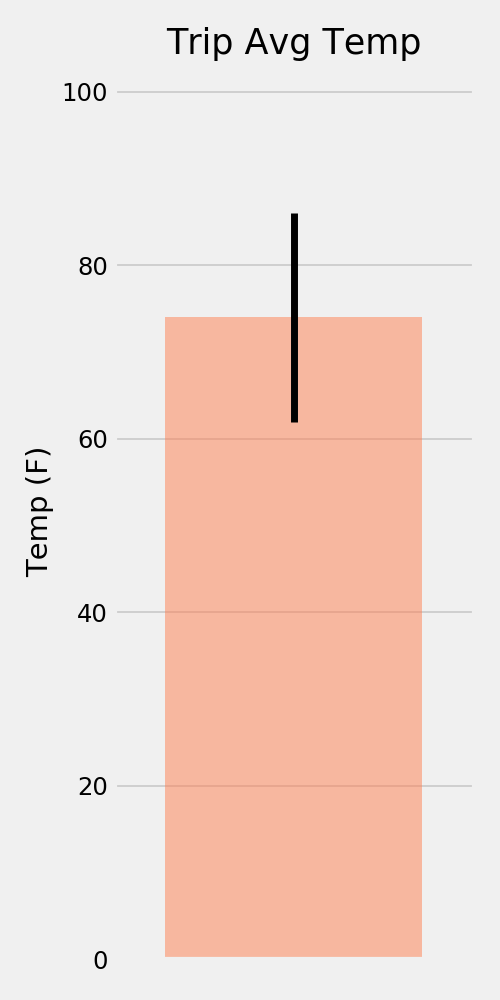

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


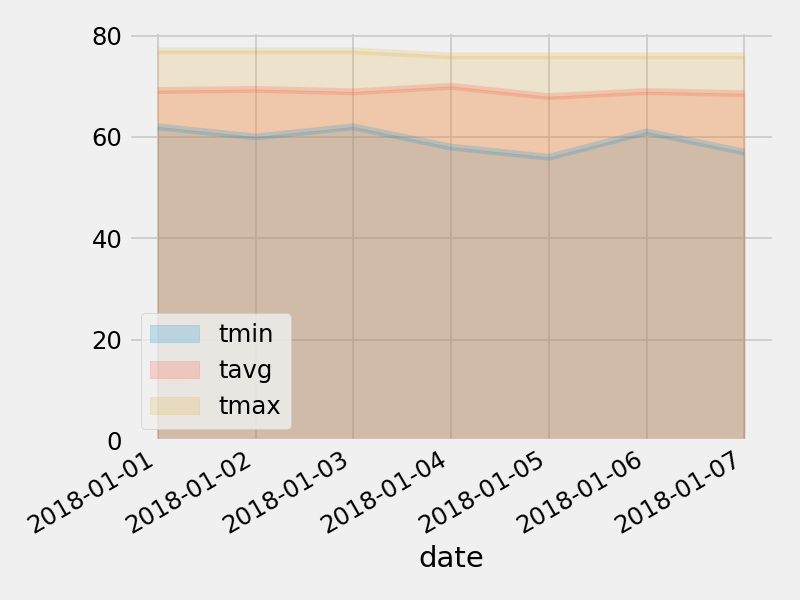

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
